<a href="https://colab.research.google.com/github/MichalMiko6211/stocks_lstm/blob/master/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import bs4
import numpy as np

#Pipelines
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MinMaxScaler, StandardScaler


Let's try to get stooq data for PEKAO? 




Create function that would fetch & preprocess data

In [0]:
def get_data(symbol):
  
  
  #Get data from Stooq: 
  
  link = "https://stooq.pl/q/d/l/?s=" + symbol + "&i=d"
  df = pd.read_csv(link)
  
  df.set_index('Data', inplace = True)
  df = df['Zamkniecie']
    
  return df

In [0]:
df = get_data('peo')

In [0]:

# scaler = FeatureUnion([("minmax", MinMaxScaler()),
#                      ("std", StandardScaler())])


scaler = StandardScaler()

data = scaler.fit_transform(df.values.reshape(-1,1))

memory_days = 3


X,Y = [],[]
for i in range(len(data)-memory_days-1):
    X.append(data[i:(i+memory_days),0])
    Y.append(data[(i+memory_days),0])

    
X, y = np.array(X),np.array(Y)


Now, we need to split data into training and test set

In [5]:
X_train,X_test = X[:int(X.shape[0]*0.95)],X[int(X.shape[0]*0.95):]
y_train,y_test = y[:int(y.shape[0]*0.95)],y[int(y.shape[0]*0.95):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

4956
261
4956
261


Actual model building - Keras

In [6]:
from keras.models import Sequential
from keras.layers import LSTM,Dense

Using TensorFlow backend.


In [7]:
model = Sequential()
model.add(LSTM(512,input_shape=(3,1)))
model.add(Dense(1))




Instructions for updating:
Colocations handled automatically by placer.


In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-9, verbose =1)

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(patience=15, verbose=1)

In [0]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

In [0]:
model.compile(optimizer='adam',loss='mse')

In [11]:
results = model.fit(X_train,y_train,epochs=200, callbacks=[checkpointer, earlystopper, reduce_lr], validation_data=(X_test,y_test),shuffle=False)

Instructions for updating:
Use tf.cast instead.
Train on 4956 samples, validate on 261 samples
Epoch 1/200
4956/4956 [==============================] - 4s 870us/step - loss: 0.0948 - val_loss: 0.0037

Epoch 00001: val_loss improved from inf to 0.00371, saving model to model.weights.best.hdf5
Epoch 2/200
4956/4956 [==============================] - 1s 262us/step - loss: 0.0053 - val_loss: 0.0038

Epoch 00002: val_loss did not improve from 0.00371
Epoch 3/200
4956/4956 [==============================] - 1s 268us/step - loss: 0.0056 - val_loss: 0.0039

Epoch 00003: val_loss did not improve from 0.00371
Epoch 4/200
4956/4956 [==============================] - 1s 269us/step - loss: 0.0056 - val_loss: 0.0039

Epoch 00004: val_loss did not improve from 0.00371
Epoch 5/200
4956/4956 [==============================] - 1s 271us/step - loss: 0.0057 - val_loss: 0.0041

Epoch 00005: val_loss did not improve from 0.00371
Epoch 6/200
4956/4956 [==============================] - 1s 268us/step - loss: 

In [0]:
import matplotlib.pyplot as plt

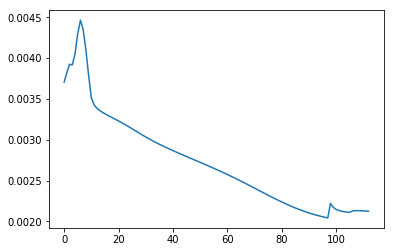

In [13]:
plt.plot(results.history['val_loss'])

In [0]:
Y_hat = model.predict(X_test)

In [15]:
Y_hat[:20]

array([[0.6427302 ],
       [0.6319224 ],
       [0.61116385],
       [0.628791  ],
       [0.60679877],
       [0.6078521 ],
       [0.5858099 ],
       [0.578973  ],
       [0.5595665 ],
       [0.4908411 ],
       [0.4950334 ],
       [0.4792577 ],
       [0.4687655 ],
       [0.485911  ],
       [0.47073138],
       [0.43064156],
       [0.41737747],
       [0.4452087 ],
       [0.44580078],
       [0.51694566]], dtype=float32)

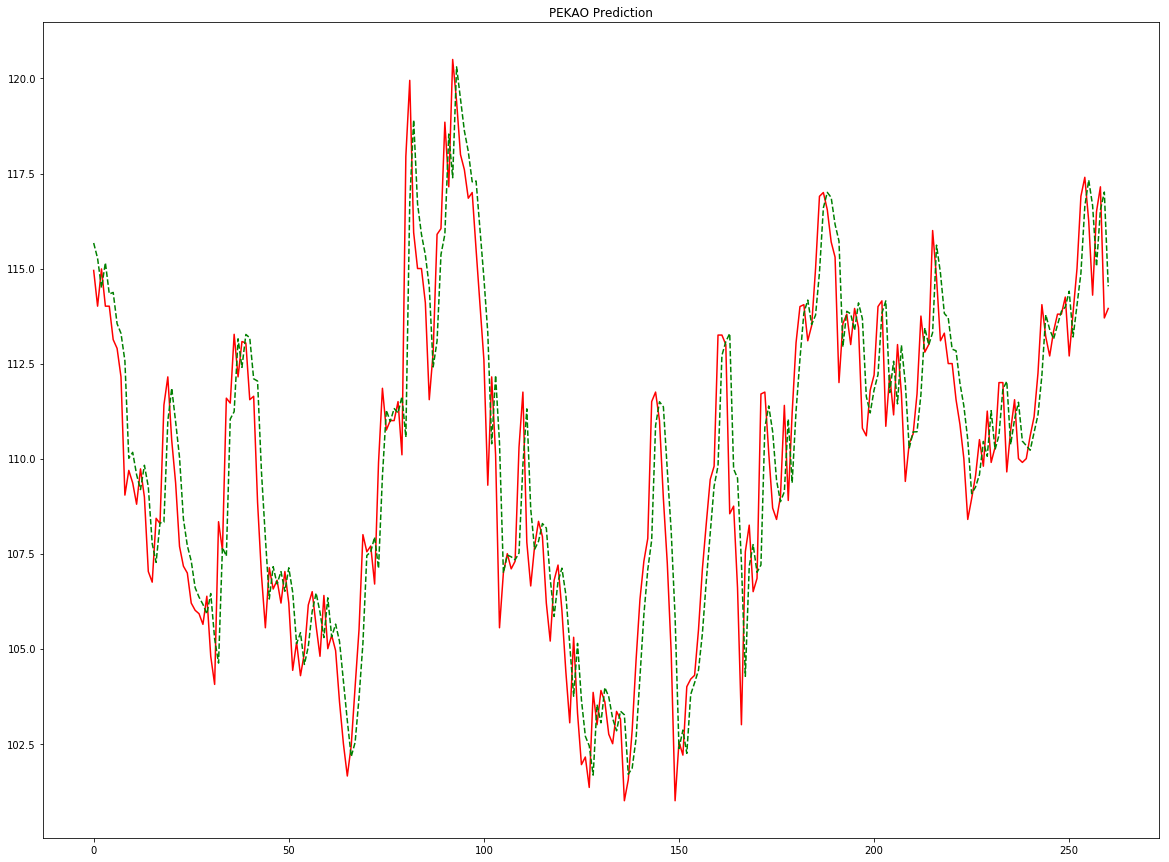

In [16]:
plt.figure(figsize=[20,15])
plt.title("PEKAO Prediction")
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), 'r' )
plt.plot(scaler.inverse_transform(Y_hat), 'g--')
plt.show()

In [17]:
X_test.shape

(261, 3, 1)

In [18]:
X_test[-2]

array([[0.60594182],
       [0.66495065],
       [0.68238507]])

In [19]:
y_test[-1]

0.59655404969726

In [0]:
last_predicted = model.predict(X_test[-2].reshape(1,3,1))

In [21]:
print('predicted:{0}, actual:{1}'.format(scaler.inverse_transform(last_predicted),scaler.inverse_transform(y_test[-3].reshape(-1,1))))

predicted:[[117.01229]], actual:[[117.15]]


In [22]:
df.tail(6)

Data
2019-04-25    114.30
2019-04-26    116.50
2019-04-29    117.15
2019-04-30    113.70
2019-05-02    113.95
2019-05-06    112.50
Name: Zamkniecie, dtype: float64

In [23]:
scaler.inverse_transform(y_test[-5:].reshape(-1,1))

array([[114.3 ],
       [116.5 ],
       [117.15],
       [113.7 ],
       [113.95]])

Predict for the future

In [26]:
df.tail(5)

Data
2019-04-26    116.50
2019-04-29    117.15
2019-04-30    113.70
2019-05-02    113.95
2019-05-06    112.50
Name: Zamkniecie, dtype: float64